# Special Mathematics Lecture: Introduction to Stochastic Calculus (Fall 2023)
## Simulation of 1D Brownian motion and solutions of the Langevin equation by Nguyen Tai Tue

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import random
from matplotlib import cm
plt.rcParams["mathtext.fontset"]='cm'
plt.rcParams["font.family"]='serif'

## Uniform Distribution
The code below generates a sample of the uniform distribution $U_{(0,1)}$. Then we draw two histograms of this sample and compare them with the probability density function $p$ (PDF) and the cumulative distribution function $F$ (CDF) of $U_{(0,1)}$ which are $~\Pi:\mathbb{R}\to\mathbb{R}$ and $~F:\mathbb{R}\to[0,1]$ such that
$$\Pi(x)= \begin{cases}
1,\quad x\in(0,1),\\ 
0,\quad\text{elsewhere},
\end{cases}$$

$$F(x)= \begin{cases}
x,\quad x\in[0,1],\\ 
0,\quad\text{elsewhere}.
\end{cases}$$

(0.0, 1.0)

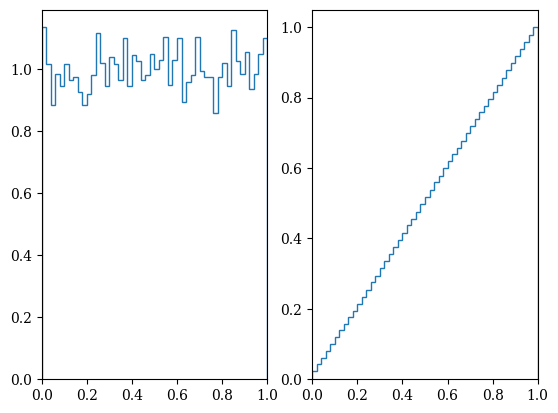

In [2]:
u=np.random.random(10000)
counts, bins = np.histogram(u, bins=50)
fig_U,ax_U=plt.subplots(1,2)
ax_U[0].hist(bins[:-1], bins, weights=counts, density=True, histtype='step')
ax_U[1].hist(bins[:-1], bins, weights=counts, density=True, cumulative=True, histtype='step')
ax_U[0].set_xlim([0,1])
ax_U[1].set_xlim([0,1])


## Box-Muller Method
The code below generates two samples of the normal distribution $N(0,1)$ by the **Box-Muller method**: 

Samples of two independent random variables $Z_1,Z_2\sim N(0,1)$ can be generated as follows.
1. Generate $u_1,u_2\overset{s}{\sim} U_{[0,1]}$
2. Set $r:=\sqrt{-2\ln(u_1)},~v:=2\pi u_2$.
3. Set $z_1:=r\cos(v),~z_2:=r\sin(v).$
   
Then $z_1,z_2\overset{s}{\sim} N(0,1).$

We also draw two histograms of the sample of $Z_1$ and compare them with the CDF and the PDF of $N(0,1)$ which are $~\Pi:\mathbb{R}\to\mathbb{R}$ and $~\Phi:\mathbb{R}\to[0,1]$ such that
$$\Pi(x)= \frac{1}{\sqrt{2\pi}}e^{-x^2/2},$$

$$\Phi(x)= \frac{1}{\sqrt{2\pi}}\int_{-\infty}^x e^{-t^2/2}\mathrm{d}t.$$

Cov(z1,z2)= -0.0005163491637353261


(array([1.000e-04, 2.000e-04, 2.000e-04, 4.000e-04, 7.000e-04, 7.000e-04,
        9.000e-04, 1.300e-03, 1.900e-03, 3.000e-03, 4.800e-03, 7.500e-03,
        1.170e-02, 1.870e-02, 2.850e-02, 4.080e-02, 5.750e-02, 7.620e-02,
        1.012e-01, 1.345e-01, 1.736e-01, 2.197e-01, 2.694e-01, 3.200e-01,
        3.768e-01, 4.453e-01, 5.084e-01, 5.701e-01, 6.310e-01, 6.881e-01,
        7.417e-01, 7.899e-01, 8.348e-01, 8.735e-01, 9.066e-01, 9.306e-01,
        9.505e-01, 9.646e-01, 9.755e-01, 9.839e-01, 9.900e-01, 9.942e-01,
        9.963e-01, 9.974e-01, 9.984e-01, 9.990e-01, 9.993e-01, 9.996e-01,
        9.999e-01, 1.000e+00]),
 array([-4.40065442, -4.23707215, -4.07348989, -3.90990763, -3.74632537,
        -3.58274311, -3.41916084, -3.25557858, -3.09199632, -2.92841406,
        -2.7648318 , -2.60124953, -2.43766727, -2.27408501, -2.11050275,
        -1.94692049, -1.78333822, -1.61975596, -1.4561737 , -1.29259144,
        -1.12900918, -0.96542691, -0.80184465, -0.63826239, -0.47468013,
        -0.

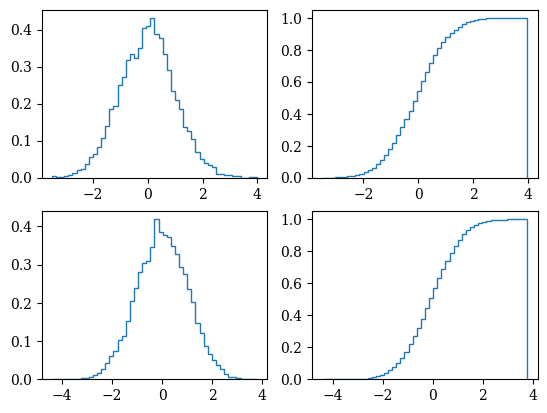

In [3]:
#Box-Muller method for generating 2 independent Gaussian random variable
u1=np.random.random(10000)
u2=np.random.random(10000)
r=np.sqrt(-2*np.log(u1))
v=2*np.pi*u2
z1=r*np.cos(v)
z2=r*np.sin(v)
print('Cov(z1,z2)=', (z1*z2).mean()-z1.mean()*z2.mean())
fig_Z,ax_Z=plt.subplots(2,2)
counts, bins = np.histogram(z1, bins=50)
ax_Z[0][0].hist(bins[:-1], bins, weights=counts, density=True, histtype='step')
ax_Z[0][1].hist(bins[:-1], bins, weights=counts, density=True, cumulative=True, histtype='step')
counts, bins = np.histogram(z2, bins=50)
ax_Z[1][0].hist(bins[:-1], bins, weights=counts, density=True, histtype='step')
ax_Z[1][1].hist(bins[:-1], bins, weights=counts, density=True, cumulative=True, histtype='step')

## Brownian Motion

Using Box-Muller method, we write a function for generating `num_sample` sample values of `N` random variables $\sim N(0,1)$. 

`num_sample=10000` by default.

In [4]:
def Z(N, num_sample=10000):
    N2=N//2
    u1=np.random.random((N2,num_sample))
    u2=np.random.random((N2,num_sample))
    r=np.sqrt(-2*np.log(u1))
    v=2*np.pi*u2
    z1=r*np.cos(v)
    z2=r*np.sin(v)
    samples=np.concatenate((z1,z2), axis=0)
    return np.array(samples)

Let $n\geq 1$ and $0=t_0<t_1<\ldots<t_n$ be a time grid. Initialize $b_0:=0$.

For $j=1$ to $n$
1. Generate $z_j\overset{s}{\sim} N(0,t_j-t_{j-1})$,
2. Set $b_{t_j}:=b_{t_{j-1}}+z_j$.

Then $(b_0,b_{t_1},\ldots,b_{t_n})\overset{s}{\sim} (B_0,B_{t_1},\ldots,B_{t_n})$.

In the following code, we use a constant time step `dt`. We generate `10000` paths of Brownian motion.

In [5]:
#Brownian motion by using definition
N=15001
T=1.
t=np.linspace(0,T,N)
dt=T/(N-1)
ZN=Z(N-1)
B=[np.zeros(10000)]
for i in range(N-1):
    Bi=B[-1]+ZN[i]*np.sqrt(dt)
    B.append(Bi)
B=np.array(B)
samples_B=B.transpose()

We approximate expectation values of Brownian at each times $t_j$ by 
$$\mathbb{E}(B_{t_j})\approx\overline{b_{t_j}}= \frac{1}{N_{\text{sample}}}\sum^{N_{\text{sample}}}_{m=1}b^m_{t_j}.$$
In theory, $\mathbb{E}(B_{t})=0$ for any $t\geq 0$.

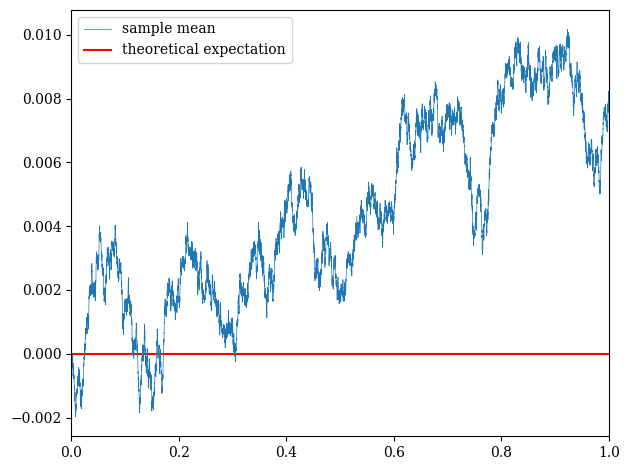

In [6]:
mean_B=samples_B.mean(axis=0)
fig_EB,ax_EB=plt.subplots()
ax_EB.plot(t,mean_B,linewidth=0.5, label='sample mean')
ax_EB.axhline(0.0, color="red",zorder=-1, label='theoretical expectation')
ax_EB.set_xlim([0,1])
ax_EB.legend()
fig_EB.tight_layout()

In [7]:
fig_EB.savefig("EB.pdf")

We approximate the covariance: 
$$\mathrm{Cov}(B_{t_j},B_{t_k})\approx \frac{1}{N_{\text{sample}}}\sum^{N_{\text{sample}}}_{m=1}(b^m_{t_j}-\overline{b_{t_j}})(b^m_{t_k}-\overline{b_{t_k}}).$$

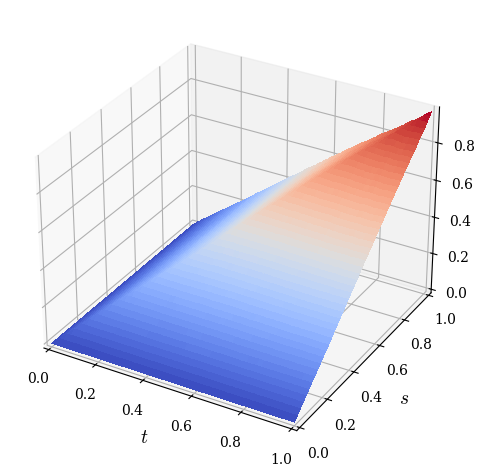

In [8]:
sCov_B=np.cov(B)
T,S=np.meshgrid(t,t)
fig_sCovB,ax_sCovB=plt.subplots(subplot_kw={"projection": "3d"})
ax_sCovB.plot_surface(T,S, sCov_B, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, rasterized=True)
ax_sCovB.set_xlim([0.,1.])
ax_sCovB.set_ylim([0.,1.])
ax_sCovB.set_xlabel(r'$t$',fontsize=14)
ax_sCovB.set_ylabel(r'$s$',fontsize=14)
fig_sCovB.tight_layout()

In [9]:
fig_sCovB.savefig("sCovB.pdf", dpi=2160)

In theory, $$\mathrm{Cov}(B_{t},B_{s})=t\wedge s=\min\{t,s\}.$$
We plot the difference between the covariance of our simulation and of the theory.

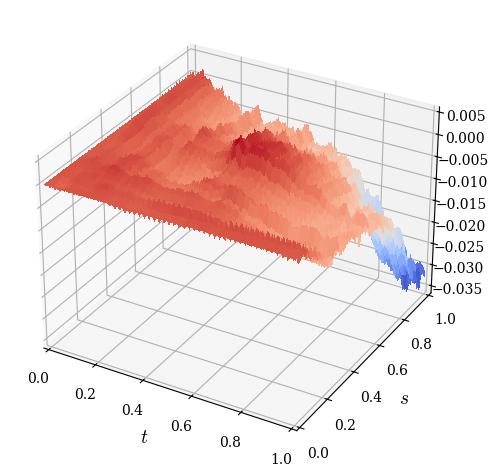

In [10]:
Cov_B=np.minimum(T,S)
Cov_B_diff = sCov_B - Cov_B
fig_CovB,ax_CovB=plt.subplots(subplot_kw={"projection": "3d"})
ax_CovB.plot_surface(T,S, Cov_B_diff, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, rasterized=True)
ax_CovB.set_xlim([0.,1.])
ax_CovB.set_ylim([0.,1.])
ax_CovB.set_xlabel(r'$t$',fontsize=14)
ax_CovB.set_ylabel(r'$s$',fontsize=14)
fig_CovB.tight_layout()

In [11]:
fig_CovB.savefig("CovB_diff.pdf", dpi=2160)

We draw `10` random paths of Brownian motion.

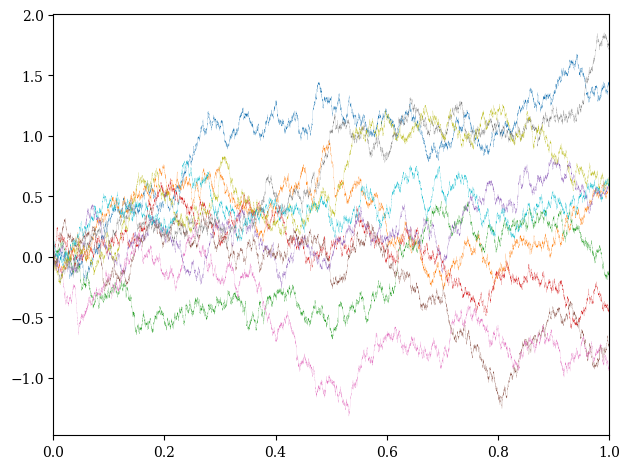

In [12]:
samples_B_k=random.choices(samples_B,k=10)
fig_B,ax_B=plt.subplots()
for sample in samples_B_k:
    ax_B.plot(t, sample,linewidth=0.1)
ax_B.set_xlim([0,1])
fig_B.tight_layout()

In [13]:
fig_B.savefig("Brownian motion.pdf")

## Lagnevin equation

The Langevin equation with an initial condition is
$$\mathrm{d}X_t=-\beta X_t\mathrm{d}t+\alpha\mathrm{d}B_t,\qquad X_0=x_0,$$
for $t\in[0,T]$, $\beta>0$, and any $\alpha$. The solution of this equation is called the **Ornstein-Uhlenbeck process**.

We can solve this equation numerically by Euler scheme: Let $T>0$, $n\geq 1$, $0=t_0<t_1<\ldots<t_n$ be a time grid, and $x_0$ be the initial position.

For $j=1$ to $n$
1. Generate $z_j\overset{s}{\sim} N(0,t_j-t_{j-1}),$
2. Set $x_{t_j}:=x_{t_{j-1}}-\beta x_{j-1}(t_j-t_{j-1}) + \alpha z_j$.
   
Then $(x_0,x_{t_1},\ldots,x_{t_n})\overset{s}{\sim} (X_0,X_{t_1},\ldots,X_{t_n})$ approximately, where $(X_t)_{t\in[0,T]}$ is the solution of the Langevin equation.


In [14]:
#Solve Langevin equation using Euler scheme
alpha=1.0
beta=1.
x0=0.

N=15001
T=1.
dt=T/(N-1)
t=np.linspace(0,T,N)
ZN=Z(N-1)
X=[x0*np.ones(10000)]
for i in range(N-1):
    zi=ZN[i]*np.sqrt(dt)
    Xi=X[-1]-beta*X[-1]*dt+alpha*zi
    X.append(Xi)
X=np.array(X)
samples_X=X.transpose()

We approximate expectation values of the solution $X_{t_j}$ for $0\leq j\leq n$ by 
$$\mathbb{E}(X_{t_j})\approx\overline{x_{t_j}}= \frac{1}{N_{\text{sample}}}\sum^{N_{\text{sample}}}_{m=1}x^m_{t_j}.$$
In theory, $\mathbb{E}(X_{t})=x_0e^{-\beta t}$ for any $t\geq 0$.

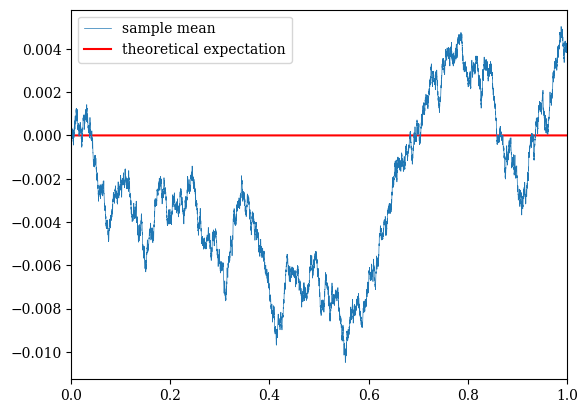

In [15]:
smean_X=samples_X.mean(axis=0)
mean_X=x0*np.exp(-beta*t)
fig_EX,ax_EX=plt.subplots()
ax_EX.plot(t,smean_X,linewidth=0.5, label='sample mean')
ax_EX.plot(t,mean_X,color="red",zorder=-1, label='theoretical expectation')
ax_EX.set_xlim((0,1))
ax_EX.legend()

In [16]:
fig_EX.savefig("EX.pdf")

We approximate the covariance: 
$$\mathrm{Cov}(X_{t_j},X_{t_k})\approx \frac{1}{N_{\text{sample}}}\sum^{N_{\text{sample}}}_{m=1}(x^m_{t_j}-\overline{x_{t_j}})(x^m_{t_k}-\overline{x_{t_k}}).$$

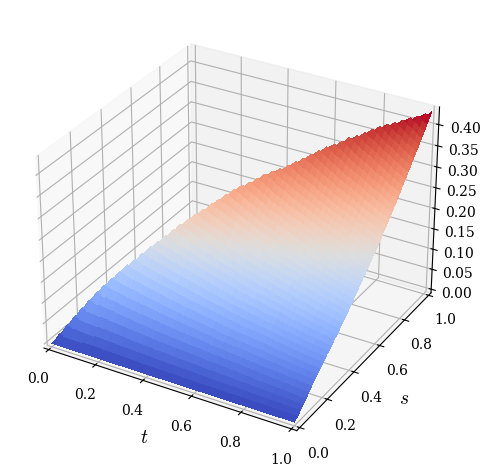

In [17]:
sCov_X=np.cov(X)
T,S=np.meshgrid(t,t)
fig_sCovX,ax_sCovX=plt.subplots(subplot_kw={"projection": "3d"})
ax_sCovX.plot_surface(T,S, sCov_X, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, rasterized=True)
ax_sCovX.set_xlim([0.,1.])
ax_sCovX.set_ylim([0.,1.])
ax_sCovX.set_xlabel(r'$t$',fontsize=14)
ax_sCovX.set_ylabel(r'$s$',fontsize=14)
fig_sCovX.tight_layout()

In [18]:
fig_sCovX.savefig("sCovX.pdf", dpi=2160)

In theory, $$\mathrm{Cov}(X_{t},X_{s})=\frac{\alpha^2}{2\beta}e^{-\beta|t-s|}\left(1-e^{-2\beta(t\wedge s)}\right).$$

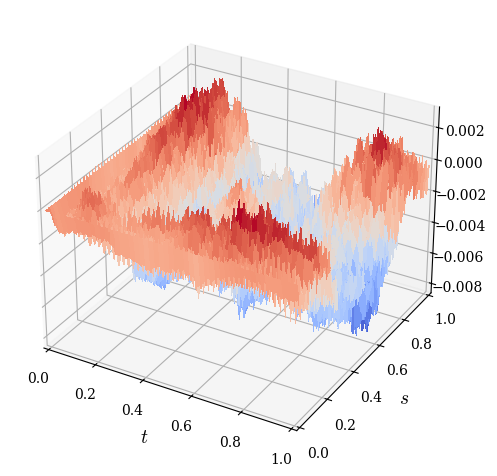

In [19]:
Cov_X=(alpha**2/(2*beta)) * np.exp(-beta*np.fabs(T-S)) * (1-np.exp(-2*beta*np.minimum(T,S)))
Cov_X_diff=sCov_X-Cov_X
fig_CovX,ax_CovX=plt.subplots(subplot_kw={"projection": "3d"})
ax_CovX.plot_surface(T,S, Cov_X_diff, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, rasterized=True)
ax_CovX.set_xlim([0.,1.])
ax_CovX.set_ylim([0.,1.])
ax_CovX.set_xlabel(r'$t$',fontsize=14)
ax_CovX.set_ylabel(r'$s$',fontsize=14)
fig_CovX.tight_layout()

In [20]:
fig_CovX.savefig("CovX_diff.pdf", dpi=2160)

We draw `10` paths of the solution.

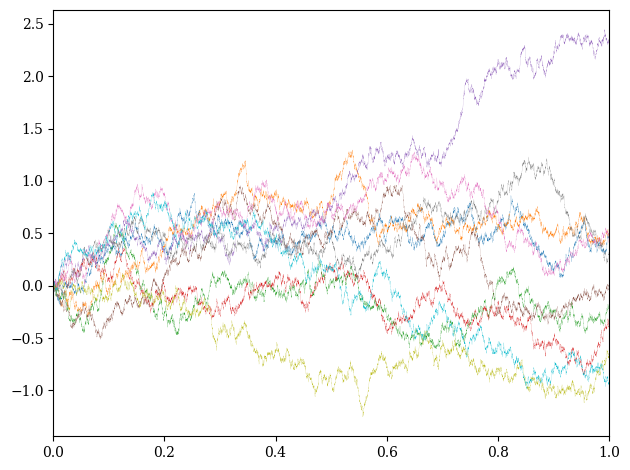

In [21]:
samples_X_k=random.choices(samples_X,k=10)
fig_X,ax_X=plt.subplots()
for sample in samples_X_k:
    ax_X.plot(t, sample,linewidth=0.1)
ax_X.set_xlim([0,1])
fig_X.tight_layout()

In [22]:
fig_X.savefig("Ornstein-Uhlenbeck.pdf")

Now we try another simulations for $x_0=1$, $\beta=2$.

In [23]:
#Solve Langevin equation using Euler scheme for x_0=1, beta=2
alpha=1.0
beta=2.
x0=1.

N=15001
T=1.
dt=T/(N-1)
t=np.linspace(0,T,N)
ZN=Z(N-1)
X=[x0*np.ones(10000)]
for i in range(N-1):
    zi=ZN[i]*np.sqrt(dt)
    Xi=X[-1]-beta*X[-1]*dt+alpha*zi
    X.append(Xi)
X=np.array(X)
samples_X=X.transpose()

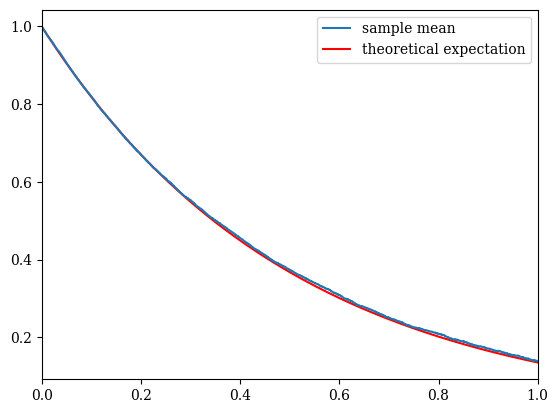

In [24]:
smean_X=samples_X.mean(axis=0)
mean_X=x0*np.exp(-beta*t)
fig_EX,ax_EX=plt.subplots()
ax_EX.plot(t,smean_X, label='sample mean')
ax_EX.plot(t,mean_X,color="red",zorder=-1, label='theoretical expectation')
ax_EX.set_xlim((0,1))
ax_EX.legend()

In [25]:
fig_EX.savefig("EX_another.pdf")

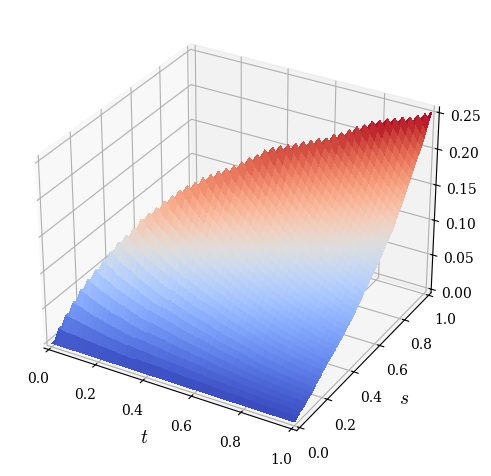

In [26]:
sCov_X=np.cov(X)
T,S=np.meshgrid(t,t)
fig_sCovX,ax_sCovX=plt.subplots(subplot_kw={"projection": "3d"})
ax_sCovX.plot_surface(T,S, sCov_X, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, rasterized=True)
ax_sCovX.set_xlim([0.,1.])
ax_sCovX.set_ylim([0.,1.])
ax_sCovX.set_xlabel(r'$t$',fontsize=14)
ax_sCovX.set_ylabel(r'$s$',fontsize=14)
fig_sCovX.tight_layout()

In [27]:
fig_sCovX.savefig("sCovX_another.pdf", dpi=2160)

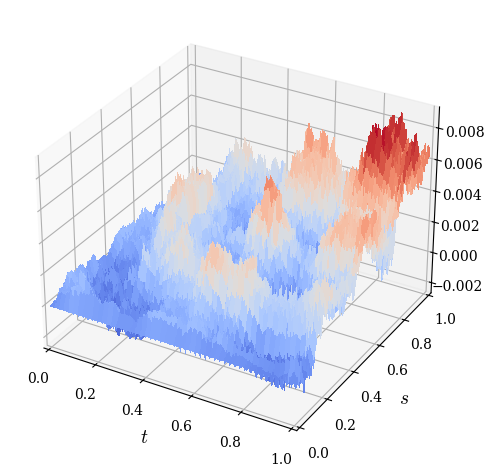

In [28]:
sCov_X=np.cov(X)
T,S=np.meshgrid(t,t)
Cov_X=(alpha**2/(2*beta)) * np.exp(-beta*np.fabs(T-S)) * (1-np.exp(-2*beta*np.minimum(T,S)))
Cov_X_diff=sCov_X-Cov_X
fig_CovX,ax_CovX=plt.subplots(subplot_kw={"projection": "3d"})
ax_CovX.plot_surface(T,S, Cov_X_diff, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, rasterized=True)
ax_CovX.set_xlim([0.,1.])
ax_CovX.set_ylim([0.,1.])
ax_CovX.set_xlabel(r'$t$',fontsize=14)
ax_CovX.set_ylabel(r'$s$',fontsize=14)
fig_CovX.tight_layout()

In [29]:
fig_CovX.savefig("CovX_diff_another.pdf", dpi=2160)

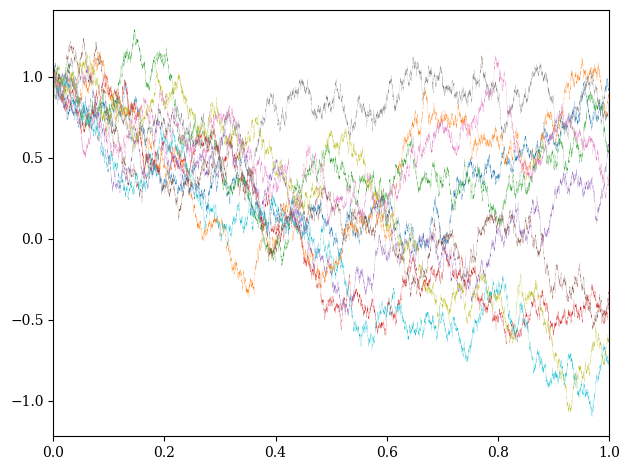

In [30]:
samples_X_k=random.choices(samples_X,k=10)
fig_X,ax_X=plt.subplots()
for sample in samples_X_k:
    ax_X.plot(t, sample,linewidth=0.1)
ax_X.set_xlim([0,1])
fig_X.tight_layout()

In [31]:
fig_X.savefig("Ornstein-Uhlenbeck_another.pdf")